In [1]:
print("hello")

hello


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from torchvision.transforms import functional as TF
from PIL import Image
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def show_images(loader):
    images, labels = next(iter(loader))
    grid_img = torchvision.utils.make_grid(images, nrow=8)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid_img.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()



In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split


transform = transforms.Compose([
    transforms.ToTensor(),
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Split the training dataset into train and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# Create DataLoader for the train set
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Create DataLoader for the validation set
valloader = DataLoader(valset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


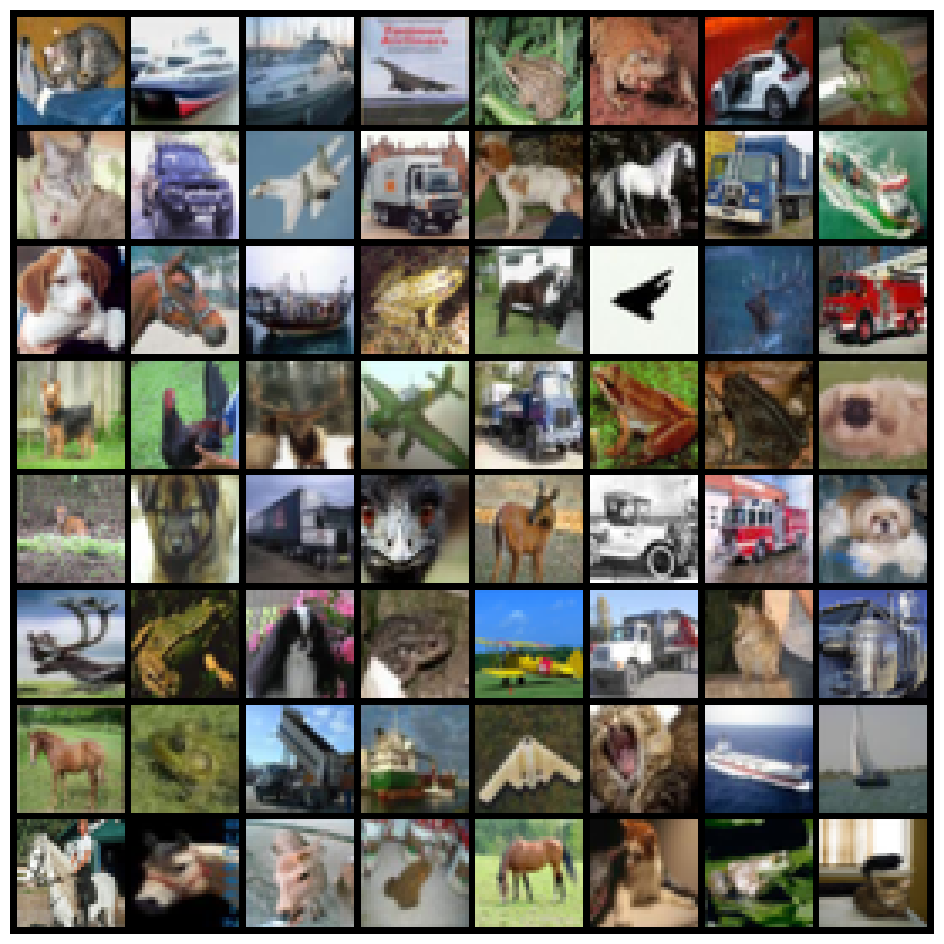

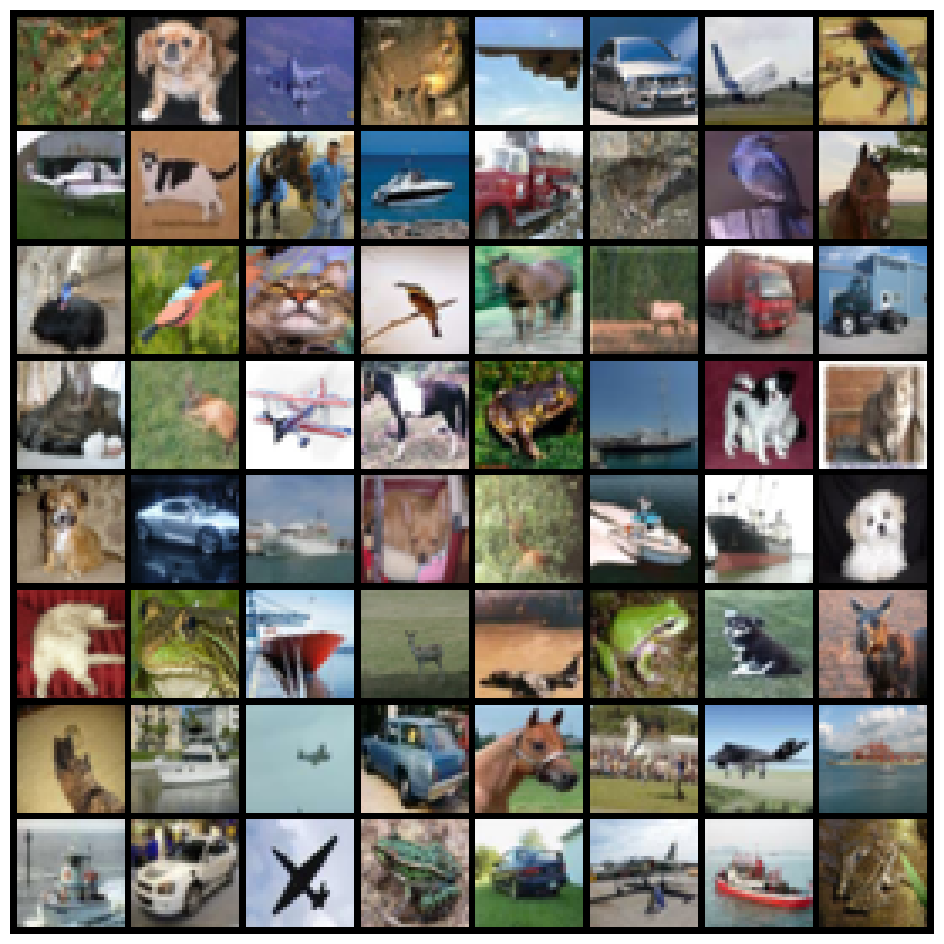

In [5]:
# Show images from the training set
show_images(testloader)
show_images(trainloader)

In [6]:
import random

class RotateDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __getitem__(self, index):
        img, label = self.dataset[index]
        rotation_label = random.choice([0, 1, 2, 3])  # 0 = 0°, 1 = 90°, 2 = 180°, 3 = 270°
        img = transforms.functional.rotate(img, rotation_label * 90)
        return img, rotation_label  # Return rotated image and rotation label
    
    def __len__(self):
        return len(self.dataset)

# Use the RotateDataset to add rotation augmentation
rot_trainset = RotateDataset(trainset)
rot_trainloader = torch.utils.data.DataLoader(rot_trainset, batch_size=64, shuffle=True)


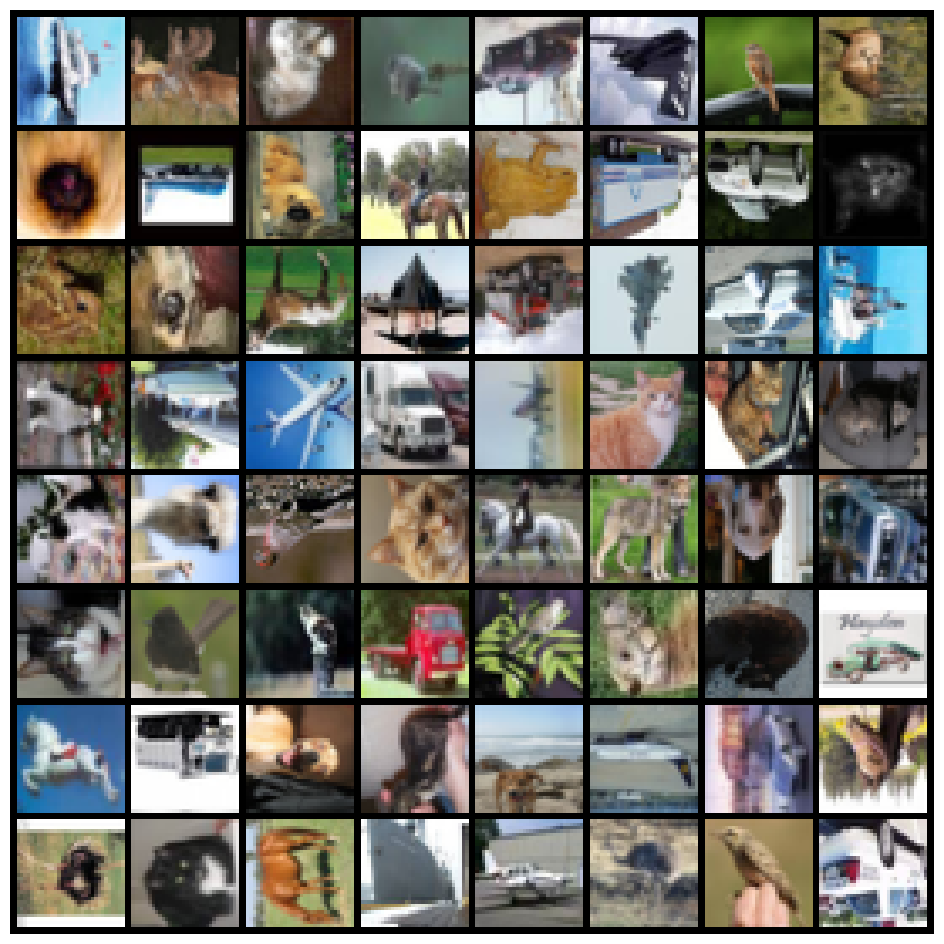

In [7]:
show_images(rot_trainloader)


In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

# Base ResNet Backbone for both tasks
class ResNetBase(nn.Module):
    def __init__(self):
        super(ResNetBase, self).__init__()
        self.backbone = models.resnet18(weights=None)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  # Remove last fully connected layer

    def forward(self, x):
        return self.backbone(x)

# Jigsaw ResNet model
class JigsawResNet(nn.Module):
    def __init__(self, num_patches, num_permutations):
        super(JigsawResNet, self).__init__()
        self.base = ResNetBase()  # Use the shared ResNet base
        self.fc = nn.Sequential(
            nn.Linear(512 * num_patches, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_permutations)
        )

    def forward(self, x):
        batch_size, num_patches, channels, height, width = x.shape
        patches = []

        for i in range(num_patches):
            patch_features = self.base(x[:, i])  # Extract features for each patch
            patch_features = torch.flatten(patch_features, start_dim=1)
            patches.append(patch_features)

        concatenated_features = torch.cat(patches, dim=1)
        output = self.fc(concatenated_features)
        return output

# Rotation ResNet model
class ResNetRotation(nn.Module):
    def __init__(self):
        super(ResNetRotation, self).__init__()
        self.base = ResNetBase()  # Use the shared ResNet base
        self.fc = nn.Linear(512, 4)  # Output classes: 0, 90, 180, 270 degrees

    def forward(self, x):
        x = self.base(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Initialize the models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_permutations = 1000
num_patches = 9

jigsaw_model = JigsawResNet(num_patches=num_patches, num_permutations=num_permutations).to(device)
rotation_model = ResNetRotation().to(device)

# Initialize weights (common function)
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

jigsaw_model.apply(weights_init)
rotation_model.apply(weights_init)

# Now proceed with training the rotation model as you outlined before.


ResNetRotation(
  (base): ResNetBase(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, e

Epoch 1, Train Loss: 1.1367, Val Loss: 1.0875
Epoch 2, Train Loss: 0.9610, Val Loss: 0.9224
Epoch 3, Train Loss: 0.8937, Val Loss: 0.9451
Epoch 4, Train Loss: 0.8462, Val Loss: 0.8680
Epoch 5, Train Loss: 0.8174, Val Loss: 0.8578
Epoch 6, Train Loss: 0.7846, Val Loss: 0.7807
Epoch 7, Train Loss: 0.7551, Val Loss: 0.7761
Epoch 8, Train Loss: 0.7167, Val Loss: 0.7825
Epoch 9, Train Loss: 0.7014, Val Loss: 0.7154
Epoch 10, Train Loss: 0.6678, Val Loss: 0.7068
Epoch 11, Train Loss: 0.6409, Val Loss: 0.9510
Epoch 12, Train Loss: 0.6289, Val Loss: 0.7579
Epoch 13, Train Loss: 0.6043, Val Loss: 0.7658
Epoch 14, Train Loss: 0.5855, Val Loss: 0.6755
Epoch 15, Train Loss: 0.5749, Val Loss: 0.6868
Epoch 16, Train Loss: 0.5529, Val Loss: 0.6331
Epoch 17, Train Loss: 0.5235, Val Loss: 0.6589
Epoch 18, Train Loss: 0.5079, Val Loss: 0.6271
Epoch 19, Train Loss: 0.4866, Val Loss: 0.6289
Epoch 20, Train Loss: 0.4734, Val Loss: 0.6296
Epoch 21, Train Loss: 0.4551, Val Loss: 0.6272
Epoch 22, Train Loss: 

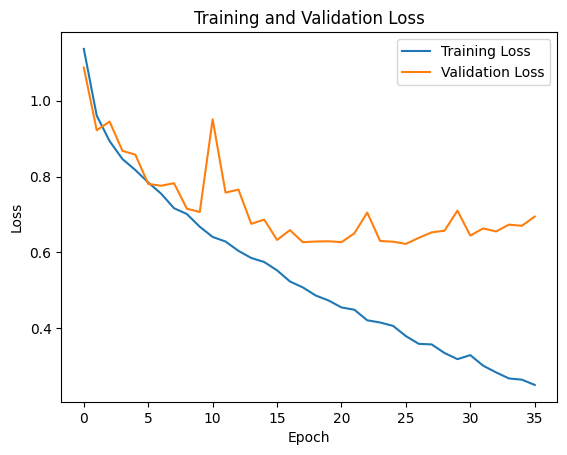

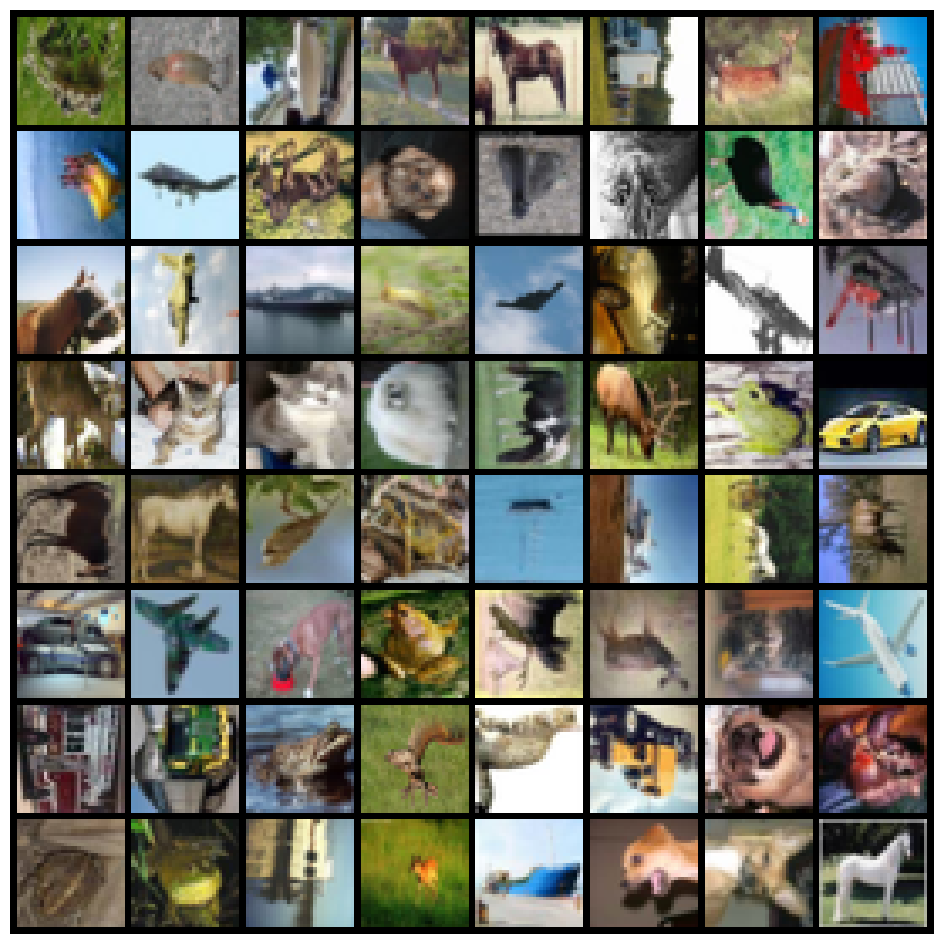

In [13]:
# Create DataLoader for rotated datasets
rot_trainset = RotateDataset(trainset)
rot_valset = RotateDataset(valset)
rot_trainloader = DataLoader(rot_trainset, batch_size=64, shuffle=True)
rot_valloader = DataLoader(rot_valset, batch_size=64, shuffle=False)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the loss function (CrossEntropyLoss) and the optimizer (Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rotation_model.parameters(), lr=0.001)

# Prepare for training
num_epochs = 100  # Adjust epochs as needed
patience = 10
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    rotation_model.train()
    running_loss = 0.0
    for images, labels in rot_trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = rotation_model(images)

        # Compute loss (CrossEntropyLoss automatically applies softmax internally)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(rot_trainloader)
    train_losses.append(train_loss)

    # Validation phase
    rotation_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in rot_valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = rotation_model(images)

            # Compute validation loss
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

    val_loss = running_val_loss / len(rot_valloader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the model
        torch.save(rotation_model.state_dict(), 'jigsaw_rotation_pretext_cross_entropy_model_CIFAR10.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Function to show images
def show_images(loader):
    images, labels = next(iter(loader))
    grid_img = torchvision.utils.make_grid(images, nrow=8)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid_img.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

# Show some example images
show_images(rot_trainloader)

Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_295004/2087055708.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rotation_model.load_state_dict(torch.load(rotation_weights_path, map_location=device))


Epoch 1, Train Loss: 1.0687, Val Loss: 0.9172
Epoch 2, Train Loss: 0.7226, Val Loss: 0.8153
Epoch 3, Train Loss: 0.5452, Val Loss: 0.8723
Epoch 4, Train Loss: 0.3950, Val Loss: 0.8295
Epoch 5, Train Loss: 0.2738, Val Loss: 0.9431
Epoch 6, Train Loss: 0.1977, Val Loss: 0.9809
Epoch 7, Train Loss: 0.1477, Val Loss: 1.1600
Epoch 8, Train Loss: 0.1255, Val Loss: 1.1244
Epoch 9, Train Loss: 0.1002, Val Loss: 1.1737
Epoch 10, Train Loss: 0.0948, Val Loss: 1.2734
Epoch 11, Train Loss: 0.0833, Val Loss: 1.2576
Epoch 12, Train Loss: 0.0821, Val Loss: 1.3038
Early stopping triggered.


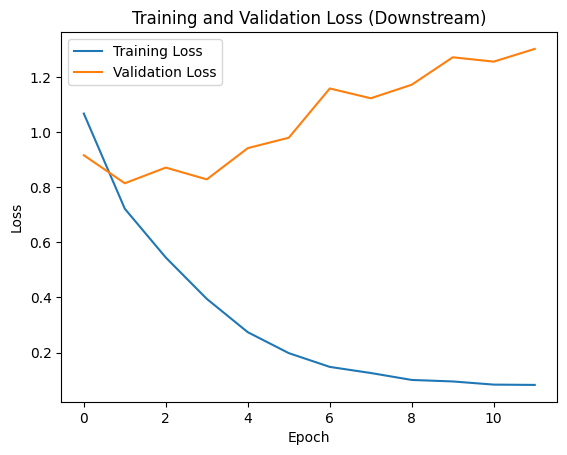

Validation Accuracy: 74.57%, Top-5 Accuracy: 97.48%


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision.models as models

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Dataset preparation (assuming CIFAR-10)
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
valset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training set for validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Downstream Classifier
class DownstreamClassifier(nn.Module):
    def __init__(self, feature_extractor, num_classes=10):
        super(DownstreamClassifier, self).__init__()
        self.feature_extractor = feature_extractor
        self.classifier = nn.Linear(512, num_classes)  # Adjust input size based on your feature extractor output

    def forward(self, x):
        x = self.feature_extractor(x)  # Use feature extractor
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))  # Average pool to (1, 1)
        x = torch.flatten(x, 1)  # Flatten the features
        x = self.classifier(x)  # Classify
        return x

# Load the ResNet rotation model's backbone
backbone = models.resnet18(weights=None)
backbone = nn.Sequential(*list(backbone.children())[:-2])  # Remove the last fully connected layer

# Initialize the ResNet rotation model
rotation_model = ResNetRotation()  # This should be defined in your code
rotation_weights_path = 'jigsaw_rotation_pretext_cross_entropy_model_CIFAR10.pth'  # Adjust to your path
rotation_model.load_state_dict(torch.load(rotation_weights_path, map_location=device))

# Initialize DownstreamClassifier with rotation_model's backbone
downstream_model = DownstreamClassifier(rotation_model.base).to(device)  # Using the base ResNet

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(downstream_model.parameters(), lr=0.001)

# Prepare for fine-tuning
num_epochs = 150  # Adjust epochs as needed
train_losses = []
val_losses = []

# Early stopping parameters
patience = 10
best_val_loss = float('inf')
patience_counter = 0

# Training loop for downstream classification
for epoch in range(num_epochs):
    # Training phase
    downstream_model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = downstream_model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Validation phase
    downstream_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = downstream_model(images)

            # Compute validation loss
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

    val_loss = running_val_loss / len(valloader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(downstream_model.state_dict(), 'jigsaw_rotation_best_downstream_classifier_model_CIFAR10.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Downstream)')
plt.show()

# Function to evaluate the downstream classifier
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    top5_correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Top-5 accuracy calculation
            top5_correct += (outputs.topk(5, dim=1).indices == labels.view(-1, 1)).sum().item()

    accuracy = correct / total
    top5_accuracy = top5_correct / total
    return accuracy, top5_accuracy

# Evaluate on validation set
val_accuracy, val_top5_accuracy = evaluate_model(downstream_model, valloader)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%, Top-5 Accuracy: {val_top5_accuracy * 100:.2f}%')

# Save the downstream model
torch.save(downstream_model.state_dict(), 'jigsaw_rotation_downstream_classifier_model_CIFAR10.pth')
